In [1]:
# Importing libraries execpt ElastiNet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


In [2]:
# Data loading and preparation part

def load_data(file_path, date_col='DATE'):
    return pd.read_csv(file_path, parse_dates=[date_col])

credit_spread_data = load_data('data/credit_spread.csv')
gdp_data = load_data('data/GDP.csv')
unemployment_data = load_data('data/UNRATE.csv')
cpi_data = load_data('data/CPI.csv')
stocks_data = load_data('data/stocks.csv')
interest_rate_data = load_data('data/interest_rates.csv')


def preprocess_data(df, start_date='2021-01-02', end_date='2022-12-31'): #until 1997 max
  df['DATE'] = pd.to_datetime(df['DATE'])
  all_dates= pd.date_range(start=df['DATE'].min(), end=df['DATE'].max(), freq='D')
  df = df.set_index('DATE').reindex(all_dates)
  df = df.ffill()
  df = df.reset_index().rename(columns={'index': 'DATE'})
  df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
  return df

credit_spread_data = preprocess_data(credit_spread_data)
gdp_data = preprocess_data(gdp_data)
unemployment_data = preprocess_data(unemployment_data)
cpi_data = preprocess_data(cpi_data)
stocks_data = preprocess_data(stocks_data)
interest_rate_data = preprocess_data(interest_rate_data)


merged_data = credit_spread_data.merge(gdp_data, on='DATE', how='outer')
merged_data = merged_data.merge(unemployment_data, on='DATE', how='outer')
merged_data = merged_data.merge(cpi_data, on='DATE', how='outer')
merged_data = merged_data.merge(stocks_data, on='DATE', how='outer')
merged_data = merged_data.merge(interest_rate_data, on='DATE', how='outer')

merged_data.replace('.', np.nan, inplace=True)

merged_data = merged_data.apply(pd.to_numeric, errors='ignore')
print(merged_data.dtypes)

DATE                int64
BAMLH0A0HYM2      float64
GDP               float64
UNRATE            float64
FPCPITOTLZGUSA    float64
SP500             float64
NASDAQCOM         float64
T10Y2Y            float64
dtype: object


In [3]:
# Data preparation for the model

imputer = SimpleImputer(strategy='mean')
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
merged_data[numeric_columns] = imputer.fit_transform(merged_data[numeric_columns])

X = merged_data.drop(columns=['BAMLH0A0HYM2', 'DATE']) 
y = merged_data['BAMLH0A0HYM2']

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
print("Number of Nan ")
print(merged_data.isna().sum())

print(merged_data)

Number of Nan 
DATE              0
BAMLH0A0HYM2      0
GDP               0
UNRATE            0
FPCPITOTLZGUSA    0
SP500             0
NASDAQCOM         0
T10Y2Y            0
dtype: int64
             DATE  BAMLH0A0HYM2        GDP  UNRATE  FPCPITOTLZGUSA  \
0    1.609546e+18      3.863598  22656.793     6.4        4.697859   
1    1.609632e+18      3.863598  22656.793     6.4        4.697859   
2    1.609718e+18      3.930000  22656.793     6.4        4.697859   
3    1.609805e+18      3.920000  22656.793     6.4        4.697859   
4    1.609891e+18      3.800000  22656.793     6.4        4.697859   
..            ...           ...        ...     ...             ...   
724  1.672099e+18      4.550000  26734.277     3.5        8.002800   
725  1.672186e+18      4.770000  26734.277     3.5        8.002800   
726  1.672272e+18      4.810000  26734.277     3.5        8.002800   
727  1.672358e+18      4.790000  26734.277     3.5        8.002800   
728  1.672445e+18      4.810000  26734.277

In [5]:
X

,GDP,UNRATE,FPCPITOTLZGUSA,SP500,NASDAQCOM,T10Y2Y
0,22656.793,6.4,4.697859,4185.246491,13296.640994,0.57679
1,22656.793,6.4,4.697859,4185.246491,13296.640994,0.57679
2,22656.793,6.4,4.697859,3700.650000,12698.450000,0.82000
3,22656.793,6.4,4.697859,3726.860000,12818.960000,0.83000
4,22656.793,6.4,4.697859,3748.140000,12740.790000,0.90000
...,...,...,...,...,...,...
724,26734.277,3.5,8.002800,3829.250000,10353.230000,-0.48000
725,26734.277,3.5,8.002800,3783.220000,10213.290000,-0.43000
726,26734.277,3.5,8.002800,3849.280000,10478.090000,-0.51000
727,26734.277,3.5,8.002800,3839.500000,10466.480000,-0.53000


In [6]:
class ElasticNetModel:
    def __init__(self, alpha=0.001, l1_ratio=0.5, max_iter=1000, tol=1e-5):
        self.alpha = alpha 
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weight = np.zeros(n_features)
        self.bias = 0

        for i in range(self.max_iter):
            y_pred = self._predict(X)

            gradient_weight = -(1/n_samples) * X.T.dot(y - y_pred) + self.alpha * ((1 - self.l1_ratio) * 2 * self.weight + self.l1_ratio* np.sign(self.weight))
            gradient_bias= -(1/n_samples) * np.sum(y - y_pred)

            weight_old = self.weight.copy()
            self.weight -= self.alpha * gradient_weight
            self.bias -= self.alpha * gradient_bias

            if np.sum(np.abs(self.weight - weight_old))<self.tol:
                break

    def predict(self, X):
        return self._predict(X)

    def _predict(self, X):
        return X.dot(self.weight) + self.bias

# copying Sklearn parameters so its easier
elastic_net = ElasticNetModel(alpha=0.001, l1_ratio=0.5, max_iter=10000, tol=1e-5)
elastic_net.fit(X_train_scaled, y_train)

y_pred = elastic_net.predict(X_test_scaled)

print("y_pred:", y_pred)


y_pred: [4.20483177 3.23070021 3.09737978 3.15345634 4.47866885 3.19642049
 3.4623124  3.60195361 3.28592167 3.17240652 3.17240652 4.56053459
 3.52949133 4.22674494 3.10049567 3.44881114 3.88469084 3.67612368
 4.13625456 3.1665509  3.32950523 4.28359403 3.18948758 4.38727476
 3.26886152 3.1382077  3.11411788 3.61121272 3.15670345 3.08733562
 3.32348109 3.24316396 3.68698739 3.73105676 3.62603329 3.15501541
 2.94203101 3.22881438 3.76910238 5.2302118  4.12221732 4.83949229
 3.10482613 5.35666577 3.25821465 3.58826159 4.38585673 4.28299069
 3.03163421 4.45627958 4.22674494 3.19777523 4.71373561 4.61550274
 4.57020092 4.15627344 4.23415034 3.5602732  3.17119589 3.09139859
 4.95393257 3.18658078 3.16757363 3.14908928 3.73387104 3.35209449
 3.6877997  4.86919407 3.52949133 3.57536811 4.31044079 4.48797149
 3.09952517 3.24498437 4.77590631 3.62199409 3.6833751  3.10228788
 3.35209449 3.62603329 4.38585673 4.12749687 2.96899205 3.07180343
 3.19642049 3.09737978 4.37488185 3.24249897 3.8479517

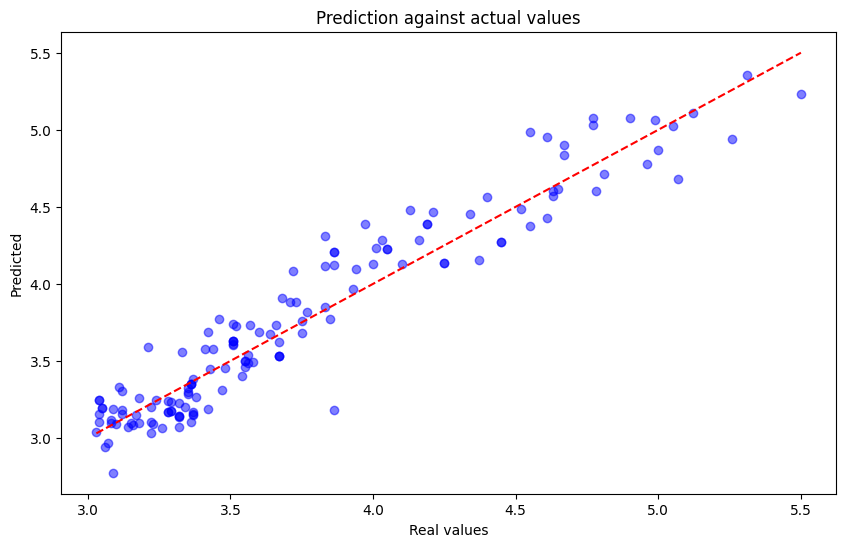

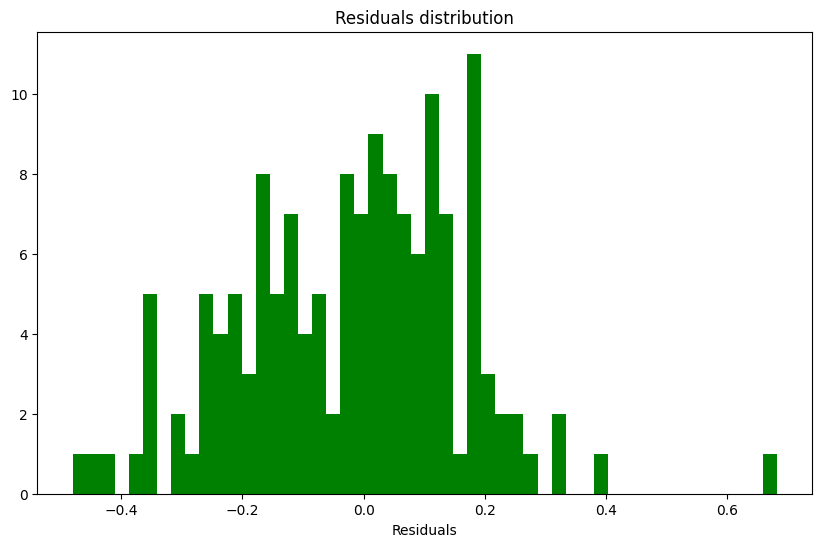

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real values')
plt.ylabel('Predicted')
plt.title('Prediction against actual values')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='green')
plt.title('Residuals distribution')
plt.xlabel('Residuals')
plt.show()


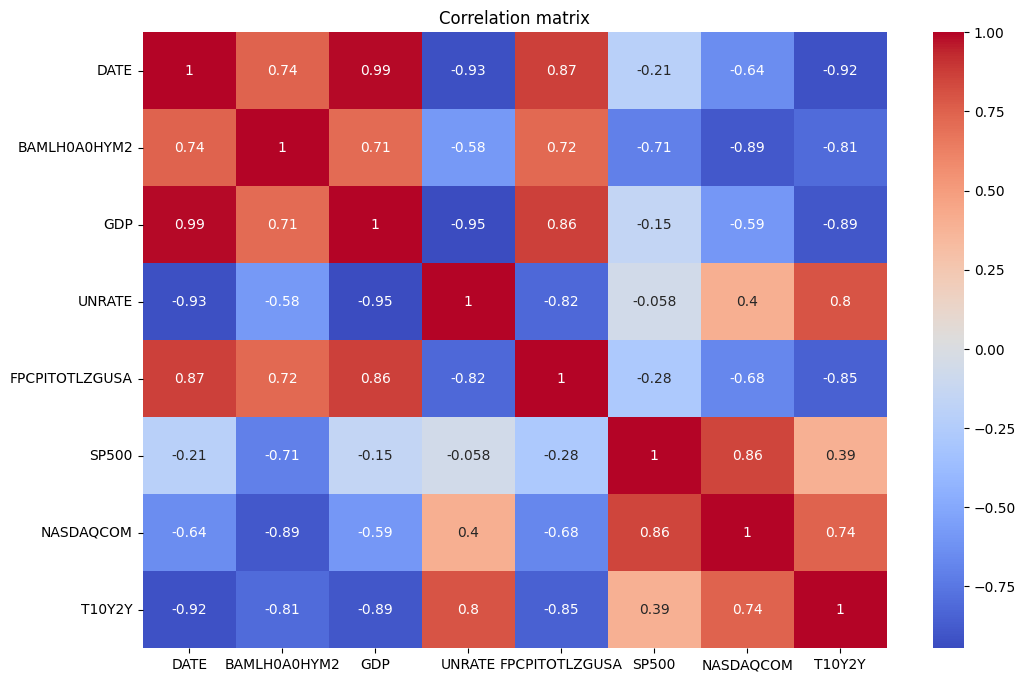

In [8]:
corr_matrix = merged_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()
